In [70]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import sidetable as stb
from sklearn.preprocessing import RobustScaler
from pandas import get_dummies


# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns


#  Gestión de warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv('datos/df_global.csv', index_col=0)

Cuando nos enfrentamos a problemas de regresión lineal vimos que eran necesarios algunos cambios antes de poder ajustar los modelos. En el caso de la regresión logística lo tendremos que hacer. Estos cambios incluyen:
- Estandarización de las variables predictoras numéricas
- Codificación de las variables categóricas
- Balanceo de la variable respuesta

Estandarizamos las numéricas:

In [4]:
numericas = df.select_dtypes(include=np.number)

In [8]:
robust= RobustScaler()

In [9]:
robust.fit(numericas)

RobustScaler()

In [11]:
X_robust= robust.transform(numericas)


array([[ 0.        ,  0.92431193,  1.26813187,  0.72727273],
       [-0.41666667, -0.38761468,  0.48241758, -1.        ],
       [ 0.        ,  3.11926606,  2.58241758, -0.18181818],
       ...,
       [-0.58333333, -0.36697248,  0.69230769, -0.81818182],
       [-0.83333333, -0.36697248,  0.69230769,  1.90909091],
       [ 0.83333333,  0.        ,  1.        , -0.09090909]])

In [17]:
numericas_robust=pd.DataFrame (X_robust, columns=(numericas.columns)+'_Robust')
numericas_robust

,Duration_Robust,Net Sales_Robust,Commision (in value)_Robust,Age_Robust
0,0.000000,0.924312,1.268132,0.727273
1,-0.416667,-0.387615,0.482418,-1.000000
2,0.000000,3.119266,2.582418,-0.181818
3,1.416667,-0.738532,0.652747,-0.272727
4,1.333333,-0.738532,0.652747,-0.272727
...,...,...,...,...
27989,-0.166667,0.412844,1.346154,1.636364
27990,-0.166667,0.412844,1.346154,1.363636
27991,-0.583333,-0.366972,0.692308,-0.818182
27992,-0.833333,-0.366972,0.692308,1.909091


In [19]:
df_global_estandarizado = pd.concat( [df,  numericas_robust], axis=1)

In [21]:
df_global_estandarizado.head(2)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age,Duration_Robust,Net Sales_Robust,Commision (in value)_Robust,Age_Robust
21,C2B,Airlines,Online,Bronze Plan,No,12.0,SINGAPORE,46.15,11.54,44.0,0.583333,-0.275229,0.0,0.909091
22,C2B,Airlines,Online,Bronze Plan,No,7.0,SINGAPORE,17.55,4.39,25.0,0.500000,0.183486,0.0,0.000000


In [23]:
df_global_estandarizado.drop (numericas.columns, axis=1, inplace=True)

In [24]:
df_global_estandarizado.head(2)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Destination,Duration_Robust,Net Sales_Robust,Commision (in value)_Robust,Age_Robust
21,C2B,Airlines,Online,Bronze Plan,No,SINGAPORE,0.583333,-0.275229,0.0,0.909091
22,C2B,Airlines,Online,Bronze Plan,No,SINGAPORE,0.500000,0.183486,0.0,0.000000


Codificamos las variables categóricas:

In [26]:
categoricas= df.select_dtypes(include='O')

In [28]:
categoricas.head(1)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Destination
21,C2B,Airlines,Online,Bronze Plan,No,SINGAPORE


In [29]:
df['Product Name'].value_counts()

Cancellation Plan                      7854
2 way Comprehensive Plan               5431
Rental Vehicle Excess Insurance        3714
Basic Plan                             3027
Bronze Plan                            2722
1 way Comprehensive Plan               1613
Silver Plan                            1504
Value Plan                             1043
Ticket Protector                        314
Gold Plan                               235
24 Protect                              153
Single Trip Travel Protect Gold         144
Single Trip Travel Protect Silver       121
Premier Plan                             66
Single Trip Travel Protect Platinum      53
Name: Product Name, dtype: int64

Product Name no tiene orden y Agency, en teoria no debería tener orden pero al explorar los datos nos encontramos con que hay una agencia (la segunda en ventas) que es la que más reclamaciones tiene. Lo mostramos a continuación. Aun así, hemos decidido no darle orden ya que por definición no lo puede tener y en el caso de querer dárselo, no podría regirse por ningún criterio objetivo ni subjetivo. Quizás pueda tratarse de un fraude o de una mala práctica en la venta pero de moemento vamos a esperar a que avance nuestro análisis.

In [40]:
#abrimos el df en el que se ven solo los reclamados
df_claim= pd.read_csv('datos/df_claim.csv', index_col=0)

In [44]:
df['Agency'].value_counts()

EPX    14898
C2B     4461
CWT     3714
JZI     3488
RAB      453
LWC      318
SSI      314
ART      168
KML      157
ADM       23
Name: Agency, dtype: int64

In [41]:
df_claim['Agency'].value_counts()

C2B    239
EPX     71
CWT     41
JZI     15
LWC     13
KML      6
SSI      2
CCR      2
RAB      1
TST      1
Name: Agency, dtype: int64

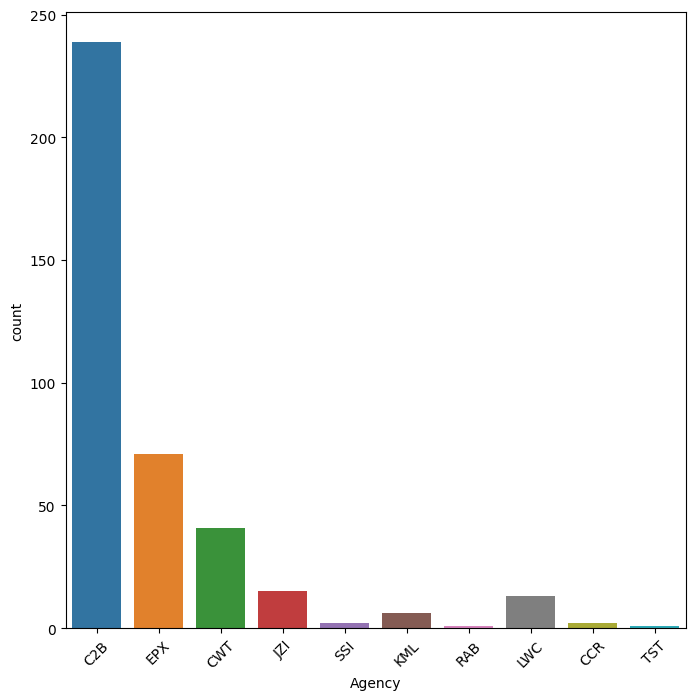

In [43]:
plt.figure (figsize= (8, 8))
sns.countplot (data=df_claim, x='Agency')
plt.xticks( rotation= 45);

Eliminamos la columna 'Channel' ya que solo nos hemos quedado con un valor para esa variable.

In [45]:
df.drop (['Distribution Channel'], axis=1, inplace=True)

En cuanto a la colummna de Destination, no tiene orden. Como esto nos generaría 125 columnas adicionales, hemos decidido eliminar los destinos minoritarios, de manera que nos quedamos solo los que suponen un 80% del total de los registros. Y el resto lo metemos en una misma categría que llamamos 'otros'.

In [50]:
len(df['Destination'].unique())

125

In [62]:
destinos = df.stb.freq (['Destination'], thresh=80 )

In [65]:
lista_paises = (destinos['Destination']).to_list()

In [68]:
df['Destination'] = df['Destination'].apply(lambda x: 'otros' if x not in lista_paises else x)


In [69]:
df['Destination'].unique()

array(['SINGAPORE', 'UNITED STATES', 'otros', 'AUSTRALIA', 'INDONESIA',
       'MALAYSIA', 'THAILAND', 'CHINA', 'VIET NAM', 'PHILIPPINES',
       'HONG KONG', 'JAPAN'], dtype=object)

In [71]:
dummies=pd.get_dummies(df['Destination'], prefix_sep = "_", prefix = "destination", dtype = int)


In [74]:
df_dummies = pd.concat([df, dummies], axis = 1)


In [76]:
df_dummies.drop(['Destination'], inplace=True, axis=1)